In [1]:
import numpy
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')

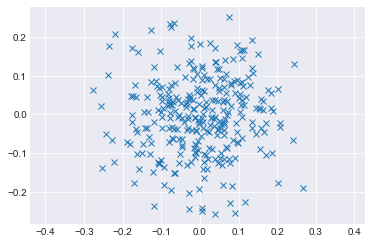

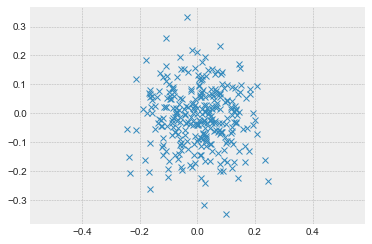

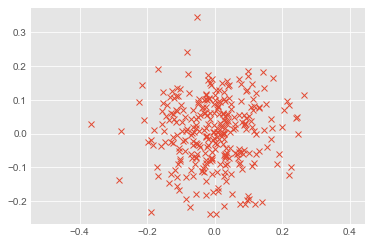

In [2]:
def complex_blob(n, scale=1.0, fixed_seed=False):
    # For a stable-but-random blob.
    if fixed_seed:
        numpy.random.seed(23)
        
    x, y = numpy.random.multivariate_normal(
        [0, 0], 
        [[scale ** 2, 0], [0, scale ** 2]], 
        n).T
    
    if fixed_seed:
        numpy.random.seed(None)

    return x + y * 1j

def plot_blob(c):
    plt.plot(c.real, c.imag, 'x')
    plt.axis('equal')
    plt.show()

# Using 'seaborn-darkgrid':
plot_blob(complex_blob(300, scale=0.1))

with plt.style.context('bmh'):
    plot_blob(complex_blob(300, scale=0.1))

with plt.style.context('ggplot'):
    plot_blob(complex_blob(300, scale=0.1))

In [3]:
# To generate a signature that will be very close to identical 
# when the starting blob is identical, we can start by picking 
# the three biggest outliers -- that is, the three phasors with 
# the greatest magnitudes. These outliers are likely to be the 
# same for blobs that are the same, even after different noise 
# is added.

# We average the angles of the three outliers, and use the 
# result as a stable reference against which to measure the 
# angular positions of the remaining phasors. The calculation 
# for this amounts to dividing all the phasors by a unit-length 
# phasor at the given angle.

# To denoise the phasors and reduce their dimension to k, we 
# multiply them by a fixed random unitary matrix, and drop all 
# but the first k dimensions. This denoises the phasors because 
# the added noise is i.i.d. in all directions, and so tends to 
# cancel itself out when summed up by the dot product. The 
# randomness of the projection matrix shouldn't change that 
# fact, though I'd like to work out a way to test that claim 
# empirically.

# The matrix is "random" in the sense that we sample it 
# pseudo-randomly and uniformly from among all unitary 
# matrices. And it is "fixed" in the sense that the seed for 
# the random number generator is predetermined, so that we get
# the same matrix every time. Otherwise, the signature for a 
# given document would change each time it was calculated, 
# making it useless as a signature!

# NOTE: Since the above was written, I've found that reversing 
# the order of these steps and picking just one outlier gives 
# better results, at least on simulated data. In other words, 
# by performing the dimension reduction first, and then the 
# rotation, basing the rotation on a single outlier, we get a 
# more stable signature. It's possible that real data may 
# differ in this respect though.

# Also, this way of doing things might limit the utility of 
# the signatures for tasks other than deduplication, because
# the stabilizing rotation might be more arbitrary, whereas we
# can hope that when the stabilizing rotation is based on 
# semantically marked outliers, it's reflecting *something* 
# about the text itself.

In [4]:
def normed_outliers(blobs, n_outliers):
    
    # Index first dimension
    blob_mags = numpy.abs(blobs)
    blob_mags_argsort = blob_mags.argsort(
        kind='stable', axis=0
    )[-n_outliers:, :]
    
    # Index second dimension
    arange_blob_mags = numpy.arange(blob_mags.shape[1])
    
    # Full index
    outliers = (blob_mags_argsort, arange_blob_mags)
    
    return blobs[outliers] / blob_mags[outliers]

def angle_offset(blobs, n_outliers):
    outlier_angles = numpy.angle(normed_outliers(blobs, n_outliers))
    offset_angle = outlier_angles.mean(axis=0)
    return numpy.cos(offset_angle) + 1j * numpy.sin(offset_angle)

def anchor_blob(blobs, n_anchors):
    anchors = angle_offset(blobs, n_anchors)
    return blobs / anchors

def haar_measure(size, fixed_seed=False):
    """
    Sample a matrix from a uniform distribution over unitary matrices. 
    
    Unitary matrices transform vectors of complex numbers without 
    changing their magnitude, and transform pairs of complex vectors 
    without changing the angle between them. Reflections and rotations
    are examples of unitary transformations, and in general you could 
    think of unitary transformations as ones that preserve circular 
    symmetries. For the purpose of random sampling, then, we should 
    look for a definition of uniformity that does the same. 
    
    It turns out that a way of measuring volume called the Haar 
    measure does just that. When you distribute points on a sphere 
    according to the Haar measure, for example, they are evenly
    distributed, so that no region of the sphere has more points than
    any other on average. The Haar measure is also provably the only
    measure with this property, so once you can show that your 
    distribution preserves this kind of symmetry, you have found the 
    Haar measure, and vice versa. There are a range of useful tests 
    based on these facts, one of which appears below in 
    `test_eigval_density` and `plot_haar_angles`. The upshot is that
    although the code in this function is relatively simple, the
    mathematics behind it is quite subtle.


    `size` determines the edge size of the matrix, which for now is 
    always square. For example, passing `5` gives a 5x5 matrix.


    `fixed_seed` samples from the same pseudorandom sequence every 
    time, in theory guaranteeing that the matrix returned will be 
    identical. However, if numpy changes their RNG algorithm at all, 
    the sequence will change, as will the matrix. So there may be 
    some argument for creating a custom Mersenne twister. This
    point technically also applies to changes to the QR decomposition 
    code. However, the numpy devs would have to change the LAPACK 
    routines they use, or the LAPACK routines themselves to change, 
    neither of which seems especially likely.
    """
    
    # `z` is a square matrix full of random values sampled from a
    # complex normal distribution.
    z = complex_blob(
        size * size, 
        fixed_seed=fixed_seed
    ).reshape((size, size)) / 2 ** 0.5
    
    # Decompose `z` into an orthogonal matrix and an 
    # upper-triangular matrix. In the `wrong` variant of this, below,
    # we just throw out `r`, hoping that the orthogonal component
    # `q` is still random enough. But it's generally not.
    q, r = numpy.linalg.qr(z)
    
    # So we have to do just a bit more work. The rationale behind
    # these additional steps is here:
    #
    # http://www.ams.org/notices/200705/fea-mezzadri-web.pdf
    #
    # Fortunately, in addition to supplying proofs, the paper 
    # supplies pseudocode.

    # Take the diagonal of `r`
    rd = numpy.diagonal(r)
    
    # Normalize the diagonal, so that each entry is a complex
    # number somewhere on the unit circle.
    rd_abs = rd / numpy.abs(rd)
    
    # Broadcasting does the same thing as multiplying by a diagonal
    # matrix with `rd_abs` along the diagonal.
    return q * rd_abs

def stable_unitary_matrix(in_dim, out_dim):
    """
    It might be tempting to cache the result of this 
    calculation, but often it is actually faster to 
    recalculate it than to look it up in a python 
    dictionary.
    """
    return haar_measure(in_dim, fixed_seed=True)[:out_dim, :]

def signature(blobs, n_anchors=1, n_dims=5):
    """
    `blobs` should be a 2D array containing one blob 
    per column, and one feature dimension per row.
    """
    projector = stable_unitary_matrix(blobs.shape[0], n_dims)
    blobs = projector @ blobs
    return anchor_blob(blobs, n_anchors)

In [5]:
# Here, the next step is to create streamlined code paths 
# to the most useful portions of the basic phasor test 
# notebook. These don't have to be perfectly clean, but 
# they should not involve a lot of circling back through 
# states, the way slice_vec_bands does, for example.

# Ideally, this will form the basis of a user-friendly 
# interface that lives in a new module, and that mostly 
# replaces the phasor module for everyday use.

# To begin with, the API will be all functions. When 
# working with objects, like sklearn models, the model 
# should be passed in as a parameter if necessary, but only 
# if necessary, i.e, if we'd be creating a new object every 
# time in a tight loop. So we won't write anything that 
# manages state at first. Maybe by the end it will be clear 
# that we ahould manage some state but that will be a 
# decision we make later.

# After thinking it through a bit more, this should all 
# be part of the update.py script. That script imports just 
# two functions from phasor.py, and although I think the 
# save function has some complicated dependencies, they 
# aren't so complicated that we can't simplify and 
# replicate them in update.py. From there we can do the 
# same for the signature save functions.
#
# There are three main dependencies:
#
# 1. load_one_sp_embedding
#    This loads the raw spacy vectors for each token. I 
# need to come up with better terms, because "embedding" 
# here refers to the underlying GloVe embeddings, but 
# elsewhere I talk about the fourier-transformed things 
# as embeddings. That's neither useful nor really all that 
# accurate.
#
#    The main thing this uses is the VectorTable class, 
# which I think is actually a pretty good class. So this 
# part of the code doesn't need a lot of work.
#    
# 2. embedding_fft 
#    This runs through a series of utility functions, 
# mostly provided by numpy. The one non-numpy function is 
# the one that divides the volume into chunks and takes the 
# average GloVe vector for each chunk. I wish I had a line 
# that checks to see whether the chunks are larger than 200 
# words or so, but I don't think I do. I will look at that 
# more carefully though. The rest uses standard numpy 
# functions to perform the actual fft and crunch and format
# data.
#
# 3. save_compact_fft
#    The result of the last step is a 2-D complex array, 
# i.e. an array of blobs in the lingo I'm using here. Each 
# blob contains all the semantic dimensions of 
# one frequency band for one volume. I think. But, I think, 
# transposed relative to the blobs here in this notebook, 
# darnit! So a blob is a column instead of a row. Crumbs and 
# sausages. And, yes, a quick check confirms that the reduce 
# matrix in PhasorSignature is on the left, but the haar 
# projector here is on the right. So I gotta refactor the 
# code in this notebook so that blobs are columns. I think 
# this must be related to the shape of the fft output... 
# 300 rows 10 columns... = 10 blobs of 300 dims... vs... 
# yeah 10 rows of 300 dims = same but transposed


# This function also decomposes the real and imaginary 
# parts because the numpy savez_compressed function doesnt 
# support complex arrays! It saves the two parts into 
# two arrays, `real` and `imag`. The end.


In [6]:
# The following portion of this notebook is dedicated to 
# testing the vectorized signature code above against a 
# simplified version of the same. There's nothing 
# particularly sophisticated about the underlying math here, 
# but correctness is critical in this part of the code.

In [7]:
def perturb_blob(blob, scale=0.05):
    """
    Randomly rotate the starting blob and add a little bit of noise.
    """
    # A single complex number.
    offset = complex_blob(1)[0]  
    offset = offset / numpy.abs(offset)
    noise = complex_blob(len(blob), scale=scale)
    blob = blob * offset
    blob += noise
    return blob

def normed_outliers_basic(blob, n_outliers):
    blob_mags = numpy.abs(blob)
    outliers = blob_mags.argsort(kind='stable')[-n_outliers:]
    normed_outliers = blob[outliers] / blob_mags[outliers]
    return normed_outliers

def angle_offset_basic(blob, n_outliers):
    # numpy.angle works on 2d arrays.
    normed_outliers = normed_outliers_basic(blob, n_outliers)
    outlier_angles = numpy.angle(normed_outliers) 
    offset_angle = outlier_angles.mean()
    return numpy.cos(offset_angle) + 1j * numpy.sin(offset_angle)

def anchor_blob_basic(blob, n_anchors):
    anchor = angle_offset_basic(blob, n_anchors)
    return blob / anchor

def signature_basic(blob, n_anchors=1, n_dims=5):
    projector = stable_unitary_matrix(len(blob), n_dims)
    blob = projector @ blob
    return anchor_blob_basic(blob, n_anchors)


def test_signature():
    # This uses too many transpositions. 
    # It obscures the ideas behind the code. 
    # Can we improve things?
    
    blob_1 = complex_blob(300)
    blob_2 = complex_blob(300)

    blob_1_perturbed = numpy.array(
        [perturb_blob(blob_1, scale=0.05) 
         for i in range(10)]).T
    blob_2_perturbed = numpy.array(
        [perturb_blob(blob_2, scale=0.05) 
         for i in range(10)]).T

    blob_1_signatures = signature(blob_1_perturbed)
    blob_1_signatures_basic = numpy.array(
        [signature_basic(p) 
         for p in blob_1_perturbed.T]).T

    blob_2_signatures = signature(blob_2_perturbed)
    blob_2_signatures_basic = numpy.array(
        [signature_basic(p) 
         for p in blob_2_perturbed.T]).T
    
    assert numpy.allclose(blob_1_signatures, 
                          blob_1_signatures_basic)
    assert numpy.allclose(blob_2_signatures, 
                          blob_2_signatures_basic)

test_signature()

In [8]:
# This portion of this notebook is devoted to testing 
# the sampling process, with particular emphasis on 
# 1) correctly generating unitary matrices, which 
# should preserve both the magnitudes of complex 
# vectors and the angles between them, and 2) sampling 
# from a uniform distribution over possible matrices, 
# as defined by the Haar measure, which ensures that 
# the eigenvalues of the matrices are smoothly distributed 
# between -pi and pi, i.e. symmetrically over the space of 
# a circle.

# There are some subtle mathematical issues raised by 
# the second problem that I don't perfectly grasp. 
# Fortunately, the issues are described by the below 
# article in enough detail that I was able to write a 
# good test.

# http://www.ams.org/notices/200705/fea-mezzadri-web.pdf 

# Unitary matrices are also used in quantum physics, 
# and it might be interesting to compare these two uses. 
# It could just be a sort of threefold coincidence -- 
# Fourier transforms + complex numbers + a need for 
# dimension reduction? But maybe that's unusual enough 
# to be notable anyway? I'll have to think about it 
# some more.

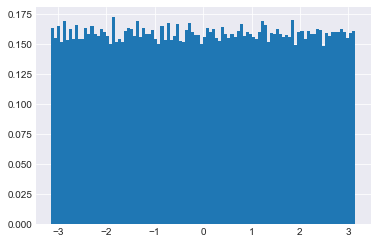

In [9]:
def _haar_measure_wrong(size):
    """
    A demonstration of an incorrect random matrix generator.
    
    Pass this to plot_haar_angles to see what makes this incorrect.
    """
    z = complex_blob(size * size).reshape((size, size)) / 2 ** 0.5
    q, r = numpy.linalg.qr(z)
    return q

def eigval_angles(u_mats):
    eig = numpy.linalg.eig
    return numpy.array([
        a 
        for u_m in u_mats
        for e_vals, e_vecs in [eig(u_m)]
        for a in numpy.angle(e_vals)
    ])

def plot_haar_angles(haar_measure_func, size=50, 
                     n_mats=1000, n_bins=100):
    n, bins, patches = plt.hist(
        eigval_angles([haar_measure_func(size) 
                       for i in range(n_mats)]), 
                      bins=n_bins, 
                      density=True)
    plt.show()

def haar_angle_density(haar_measure_func, size=50, 
                       n_mats=1000, n_bins=100):
    angles = eigval_angles(
        [haar_measure_func(size) 
         for i in range(n_mats)])
    hist, bins = numpy.histogram(
        angles, n_bins, density=True)
    return hist

def haar_angle_density_range(haar_measure_func, size=50, 
                             n_mats=1000, n_bins=100):
    density = haar_angle_density(
        haar_measure_func, size=size, 
        n_mats=n_mats, n_bins=n_bins)
    return min(density), max(density)

def haar_angle_density_range_mean_std(
        haar_measure_func, size=50, 
        n_mats=1000, n_bins=100, iters=10):
    
    ratios = [
        dmin / dmax 
        for i in range(iters)
        for dmin, dmax in [
            haar_angle_density_range(
                haar_measure_func, 
                size=size, 
                n_mats=n_mats, 
                n_bins=n_bins
            )]
    ]
    ratios = numpy.array(ratios)
    return ratios.mean(), ratios.std()

def test_angle(size=10, iters=1000):
    for i in range(iters):
        mat = haar_measure(size)
        v1 = complex_blob(size)[:, None]
        v2 = complex_blob(size)[:, None]
        assert numpy.allclose(
            v1.conj().T @ v2, 
            (mat @ v1).conj().T @ (mat @ v2)
        )

def test_mag(size=10, iters=1000):
    for i in range(iters):
        mat = haar_measure(size)
        v1 = complex_blob(size)[:, None]
        assert numpy.allclose(
            v1.conj().T @ v1, 
            (mat @ v1).conj().T @ (mat @ v1)
        )

def test_eigval_density():
    dmin, dmax = haar_angle_density_range(
        haar_measure, size=50, 
        n_mats=1000, n_bins=100)
#     0.5 is a reasonable requirement for the dmin / dmax ratio. 
#     The average for this value is around 0.85 for what I believe 
#     is a correct implementation, and the variance is very low at 
#     the given settings. 
#     In fact, it looks like the threshold lands at least 10 
#     standard deviations away from the mean, which I think 
#     implies that the heat death of the universe will come 
#     prior to a random test failure.
#     On the other hand, a modestly incorrect implementation 
#     could fail pretty frequently -- at least one out of every 
#     five tries, say -- and still be both tolerable as a solution,
#     and recognizable as a bad one. Worse solutions will fail 
#     with greater regularity, and so on. A decent test, all 
#     things considered!
    assert (dmin / dmax) > 0.5, f"Minimum ratio tolerance: 0.5;  Actual ratio: {dmin / dmax:0.04f}"

test_mag()
test_angle()
test_eigval_density()

plot_haar_angles(haar_measure)